In [1]:
# # @title Montaje de drive y carga de requerimientos
# from google.colab import drive
# drive.mount('/content/drive')

# !pip install -r '/content/drive/MyDrive/tfm_data_scientist/requirements_colab.txt' -q

# # Insert the directory
# import sys
# sys.path.insert(0,'/content/drive/MyDrive/tfm_data_scientist/notebook')

# 01. Librerías

In [2]:
import os
import json
import warnings
from random import sample

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats

from imblearn.over_sampling import SMOTE
from datasist.structdata import detect_outliers

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer , LabelEncoder , OrdinalEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# cargamos los modelos
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from common.utils import *

warnings.filterwarnings("ignore")

In [3]:
pd.__version__, tf.__version__

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# 02. Carga de datos

In [4]:
path_input = os.path.join(os.path.dirname(os.getcwd()), 'data/input/')
path_output = os.path.join(os.path.dirname(os.getcwd()), 'data/output/')
path_model = os.path.join(os.path.dirname(os.getcwd()), 'data/model/')

# # colab path
# path_input = '/content/drive/MyDrive/tfm_data_scientist/data/input/'
# path_output = '/content/drive/MyDrive/tfm_data_scientist/data/output/'

In [5]:
paths = [path_input, path_output, path_model]
for path in paths:
    os.makedirs(path, exist_ok=True)

In [6]:
data_train = pd.read_csv(path_output + 'fixes_train.csv' , low_memory=False)

# 03. Tratamiento y transformaciones

In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       100000 non-null  float64
 1   Occupation                100000 non-null  object 
 2   Annual_Income             100000 non-null  float64
 3   Monthly_Inhand_Salary     84998 non-null   float64
 4   Num_Bank_Accounts         100000 non-null  float64
 5   Num_Credit_Card           100000 non-null  float64
 6   Interest_Rate             100000 non-null  float64
 7   Num_of_Loan               100000 non-null  float64
 8   Type_of_Loan              100000 non-null  object 
 9   Delay_from_due_date       100000 non-null  float64
 10  Num_of_Delayed_Payment    92998 non-null   float64
 11  Changed_Credit_Limit      97909 non-null   float64
 12  Num_Credit_Inquiries      98035 non-null   float64
 13  Credit_Mix                79805 non-null   ob

## 03.01. Codificación de variables categóricas

In [8]:
data_train.select_dtypes(include=['object']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   Occupation             100000 non-null  object
 1   Type_of_Loan           100000 non-null  object
 2   Credit_Mix             79805 non-null   object
 3   Payment_of_Min_Amount  100000 non-null  object
 4   Payment_Behaviour      92400 non-null   object
 5   Credit_Score           100000 non-null  object
dtypes: object(6)
memory usage: 4.6+ MB


### 03.01.01. MultiLabelBinarizer Encoder: Type_of_Loan

In [9]:
mlb = MultiLabelBinarizer()

In [10]:
data_train.Type_of_Loan = data_train.Type_of_Loan.str.split(',').apply(lambda x: [j.strip() for j in x])     

In [11]:
data_train = data_train.join(pd.DataFrame(mlb.fit_transform(data_train.pop('Type_of_Loan')),
                                                            index=data_train.index,
                                                            columns=mlb.classes_))

In [12]:
# cuenta la cantidad de tipos de creditos, variable adicional (potencial multicolinealidad)
data_train['Distinct_Type_Loan'] = data_train.iloc[:, 22:].sum(axis=1, numeric_only=True)

In [13]:
# # se utiliza para eliminar las columnas generadas por el MultiLabelBinarazer
# drop_cols = data_train.iloc[:, 22:-1].columns
# data_train.drop(drop_cols, axis=1, inplace=True)

In [14]:
# # comprobación: se usa para comparar entre la lista y la codificación multinivel
# DataTypeLoan = data_train.Type_of_Loan.apply(len)
# data_train.iloc[DataTypeLoan.compare(data_train.iloc[:, 22:].sum(axis=1, numeric_only=True)).index]

### 03.01.02. Label Encoder

In [15]:
lbl = LabelEncoder()

In [16]:
label_cols = ['Occupation', 'Payment_of_Min_Amount']
for col in label_cols:
    data_train[col] = lbl.fit_transform(data_train[col])  

### 03.01.03. Ordinal Encoder

In [17]:
# listado organizado de codificación
payment_order = ['low_spent_small_value_payments',
                 'low_spent_medium_value_payments',
                 'low_spent_large_value_payments',
                 'high_spent_small_value_payments',
                 'high_spent_medium_value_payments',
                 'high_spent_large_value_payments',
                 np.nan]
credit_mix_order = ['good', 'standard', 'poor', np.nan]
credit_score_order = ['good', 'standard', 'poor']

In [18]:
# en el listado credit score va de último dado que se utiliza el 
# modelo 'ordinal' para revertir la codificación
ordinal_cols = ['Credit_Mix', 'Payment_Behaviour', 'Credit_Score']
cat_list = [credit_mix_order, payment_order, credit_score_order]

for cat, col in zip(cat_list, ordinal_cols):
    ordinal = OrdinalEncoder(categories=[cat])
    data_train[col] = ordinal.fit_transform(data_train[[col]])

In [19]:
# # codificación variable objetivo
# ordinal_cols = ['Credit_Score', 'Credit_Mix', 'Payment_Behaviour']

# ordinal = OrdinalEncoder()
# data_train[ordinal_cols] = ordinal.fit_transform(data_train[ordinal_cols])

# 04. Valores atipicos (outliers)

In [20]:
# detección de outliers
outlieres_identificados = detect_outliers(data_train, 0, data_train.columns)
print(f'Número de outliers detectados {len(outlieres_identificados)}')

Número de outliers detectados 27014


In [21]:
# 01 se eliminan los duplicados
data_train.drop(outlieres_identificados, inplace = True)

In [22]:
# # 02 técnica de winsorización / función dada en mineria de datos
# data_train = data_train.apply(lambda x: gestion_outliers(x, clase='winsor'))

In [23]:
# # 03 se reemplazan por la mediana
# for col in data_train.columns :
#     outlieres_index = detect_outliers(data_train, 0 , [col])
#     col_median = data_train[col].median()
#     data_train.loc[outlieres_index, col] = col_median

# 05. Valores perdidos (missings)

In [24]:
# 01 imputación KNN vecinos más cercanos
imputer = KNNImputer(n_neighbors=8)
Dataset = imputer.fit_transform(data_train.drop('Credit_Score', axis=1))
Dataset = pd.DataFrame(Dataset, columns=data_train.drop('Credit_Score', axis=1).columns, index=data_train.drop('Credit_Score', axis=1).index)

In [25]:
# # 02 imputación simple por la mediana
# median = SimpleImputer(missing_values=np.nan, strategy='median')
# Dataset = median.fit_transform(data_train.drop('Credit_Score', axis=1))
# Dataset = pd.DataFrame(Dataset, columns=data_train.drop('Credit_Score', axis=1).columns, index=data_train.drop('Credit_Score', axis=1).index)

In [26]:
# # 03 imputación multivariante iterativa
# iterative = IterativeImputer(max_iter=100, initial_strategy='median', random_state=42)
# Dataset = iterative.fit_transform(data_train.drop('Credit_Score', axis=1))
# Dataset = pd.DataFrame(Dataset, columns=data_train.drop('Credit_Score', axis=1).columns, index=data_train.drop('Credit_Score', axis=1).index)

In [27]:
Dataset.sample(5)

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,auto loan,credit-builder loan,debt consolidation loan,home equity loan,mortgage loan,not specified,payday loan,personal loan,student loan,Distinct_Type_Loan
43691,54.0,4.0,117851.07,9870.922500,-1.0,6.0,7.0,0.0,27.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
68941,21.0,1.0,40167.84,3552.730521,7.0,5.0,5.0,1.0,5.0,18.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22325,21.0,0.0,118875.69,9964.451458,0.0,4.0,12.0,2.0,10.0,5.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0
52580,28.0,1.0,27395.53,2414.960833,5.0,3.0,5.0,4.0,15.0,11.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,4.0
84265,19.0,8.0,62152.59,5188.382500,8.0,4.0,12.0,2.0,14.0,18.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [28]:
# # comprobación: conteo de variables multinivel
# for col in Dataset.iloc[:,21:-1].columns:
#     print(Dataset[col].value_counts())

# 06. Tramificación (Binning)
**Nota**: Esta técnica se utilizo en pro de mejorar la precisión del modelo. Sin embargo fue descartado, debido a que todas las variables sometidas a este procedimiento redujeron su participación en el ranking de importancia de características.

## 06.01 Tramificación univariable*
***Evaluación si el Binning mejora el rendimiento de la predicción***

In [29]:
# from optbinning import Scorecard, BinningProcess, OptimalBinning, ContinuousOptimalBinning
# from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks

In [30]:
# # prueba univariable
# variable= 'Total_EMI_per_month'
# V_vals = Dataset[variable].values
# O_vals = data_train.Credit_Score.values

In [31]:
# optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
# optb.fit(V_vals, O_vals)

In [32]:
# binning_table = optb.binning_table
# binning_table.build()

In [33]:
# Dataset[variable] = optb.transform(Dataset[variable].values, metric="indices") # indices, woe

## 06.02. Tramificacion multivariables
***Solución multivariante***

In [34]:
# opt_num = ['Num_Credit_Card',
#            'Num_Bank_Accounts',
#            'Num_of_Delayed_Payment',
#            'Monthly_Balance',
#            'Monthly_Inhand_Salary',
#            'Age',
#            'Amount_invested_monthly',
#            'Num_of_Loan',
#            'Annual_Income',
#            'Credit_Utilization_Ratio',
#            'Total_EMI_per_month']

In [35]:
# Y = data_train['Credit_Score'].values
# X = data_train[opt_num]
# list_variables = X.columns.values.tolist()
# list_categorical = []

In [36]:
# # se debe indentificar un criterio de selección para variables objetivo multivariable
# selection_criteria = {
#     "iv": {"min": 0.02}
# }
# binning_fit_params={
#     "purpose":{"cat_cutoff": 0.10}
# }

In [37]:
# binning_process = BinningProcess(categorical_variables=list_categorical,
#                                  variable_names=list_variables,
#                                 #  selection_criteria=selection_criteria,
#                                  binning_fit_params=binning_fit_params
#                                  )

In [38]:
# data_train_binned = binning_process.fit(X, Y)

In [39]:
# data_train_binned.get_support()
# data_train_woe = data_train_binned.transform(X, metric="mean_woe")
# data_train_woe.head()

# 07. Preparación de datos

## 07.01. Variable de control
**Nota**: Se introducen dos variables aletaorias para la relacion de las variables con respecto a la respuestas.  Si estas variables aleatorias presentan relación con la variable respuesta serán debidas puramente al azar, con lo que se pueden considerar relaciones espurias, es decir, falsas. Por tanto, las variables que presenten una menor relación con la respuesta que las variables de control, tendrán una sombra de sospecha sobre la veracidad de esa relación y por ende serán descartas.

In [40]:
# Dataset['VarAleatoria_01'] = np.random.uniform(0,1,size=Dataset.shape[0])
# Dataset['VarAleatoria_02'] = np.random.uniform(0,1,size=Dataset.shape[0])

In [41]:
# listado de variable descartadas
VarDrop = [
        #    'VarAleatoria_01',
        #    'VarAleatoria_02',
           'Credit_Utilization_Ratio',
           'Occupation',
           'Payment_Behaviour',
           'Distinct_Type_Loan',
           'not specified',
           'debt consolidation loan',
           'payday loan',
           'personal loan',
           'mortgage loan',
           'auto loan',
           'student loan',
           'credit-builder loan',
           'home equity loan'
           ]

In [42]:
Dataset.drop(VarDrop, axis=1, inplace=True)

In [43]:
# escalado de variables
scaler = StandardScaler()
scaled_data = scaler.fit_transform(Dataset)
scaled_data = pd.DataFrame(scaled_data, columns=Dataset.columns, index=Dataset.index)

In [44]:
scaled_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72986 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      72986 non-null  float64
 1   Annual_Income            72986 non-null  float64
 2   Monthly_Inhand_Salary    72986 non-null  float64
 3   Num_Bank_Accounts        72986 non-null  float64
 4   Num_Credit_Card          72986 non-null  float64
 5   Interest_Rate            72986 non-null  float64
 6   Num_of_Loan              72986 non-null  float64
 7   Delay_from_due_date      72986 non-null  float64
 8   Num_of_Delayed_Payment   72986 non-null  float64
 9   Changed_Credit_Limit     72986 non-null  float64
 10  Num_Credit_Inquiries     72986 non-null  float64
 11  Credit_Mix               72986 non-null  float64
 12  Outstanding_Debt         72986 non-null  float64
 13  Credit_History_Age       72986 non-null  float64
 14  Payment_of_Min_Amount 

## 07.03. PCA
**Nota**: Se utilizó para probar si la reduccion de dimensionalidad mejoraba el rendimiento de la predicción del modelo. Este procedimiento fue descartado deido a la reducción del rendimiento.<br>
Objetivos: Reducir dimensionalidad, evitar overfiting y manejar la posible multicolinealidad 

In [45]:
# # Load library
# from pca import pca

# # Initialize pca with default parameters
# pca_model = pca(normalize=True,n_components=0.8)

# # Fit transform
# results = pca_model.fit_transform(scaled_data)

# # Plot the explained variance
# pca_model.plot()

In [46]:
# pca_model.results['PC'].info()

## 07.04 División del dataset

In [47]:
X = scaled_data # pca_model.results['PC']
y = data_train.Credit_Score

In [48]:
y.shape, X.shape

((72986,), (72986, 18))

**Oversampling**

In [49]:
sm = SMOTE(random_state=42)
# resampleo con respecto a la variable objetivo
X_res, y_res = sm.fit_resample(X, y)

**Separación en entrenamiento y prueba**

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.2, random_state=42)

# 08. Modelamiento de ML

In [51]:
# definimos los modelos y generamos una lista con cada uno de ellos:
models = [
         ("Logistic", LogisticRegression(n_jobs=-1, random_state=42)),
         ("GaussianNB", GaussianNB()),
         ("XGB", XGBClassifier(n_jobs=-1, random_state=42)), # , scale_pos_weight=pos_weight, class_weight=class_weights
         ("RF", RandomForestClassifier(n_jobs=-1, random_state=42)),
         ("Tree", DecisionTreeClassifier(random_state=42)),
         ("SGD", SGDClassifier(n_jobs=-1, random_state=42)),
         ("OvO", OneVsOneClassifier(n_jobs=-1, estimator=RandomForestClassifier(random_state=42)))
]

evaluation_score = "accuracy"

results, names = model_evaluation(models, evaluation_score, X_res, y_res)

Metric: accuracy , KFold 
Logistic: 0.698861 (0.002786) 
Metric: accuracy , KFold 
GaussianNB: 0.691747 (0.002441) 
Metric: accuracy , KFold 
XGB: 0.827969 (0.001932) 
Metric: accuracy , KFold 
RF: 0.880595 (0.001469) 
Metric: accuracy , KFold 
Tree: 0.809136 (0.001321) 
Metric: accuracy , KFold 
SGD: 0.691564 (0.006093) 
Metric: accuracy , KFold 
OvO: 0.880862 (0.001457) 


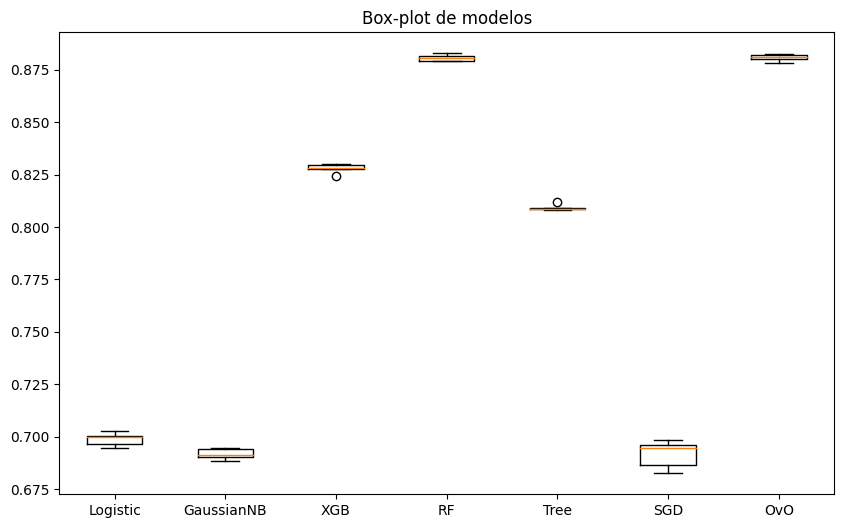

In [52]:
# realizamos una visualización de comparativa de modelos
plt.figure(figsize=(10, 6))

plt.boxplot(results)

plt.xticks(np.arange(1,len(names)+1),names)
plt.title('Box-plot de modelos')
plt.show()

In [53]:
model = RandomForestClassifier(n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [54]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['good', 'standard', 'poor']))

              precision    recall  f1-score   support

        good       0.89      0.94      0.92      8003
    standard       0.87      0.79      0.83      8004
        poor       0.88      0.91      0.90      8004

    accuracy                           0.88     24011
   macro avg       0.88      0.88      0.88     24011
weighted avg       0.88      0.88      0.88     24011



# 09. Modelamiento con NN

In [55]:
input_shape = X_res.shape[1]

In [56]:
model = Sequential()

model.add(Dense(512, input_shape=(input_shape,), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(3, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=150, restore_best_weights=True)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               9728      
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [57]:
history = model.fit(x= X_train, y= y_train, validation_data= (X_test, y_test), validation_split= 0.1, batch_size= 512, epochs=2000, verbose=1, 
          callbacks=[early_stopping])

Epoch 1/2000
188/188 [==============================] - 3s 10ms/step - loss: 0.8949 - accuracy: 0.6462 - val_loss: 0.7573 - val_accuracy: 0.7018
Epoch 2/2000
188/188 [==============================] - 2s 8ms/step - loss: 0.7489 - accuracy: 0.7112 - val_loss: 0.7140 - val_accuracy: 0.7218
Epoch 3/2000
188/188 [==============================] - 2s 8ms/step - loss: 0.7209 - accuracy: 0.7219 - val_loss: 0.6914 - val_accuracy: 0.7295
Epoch 4/2000
188/188 [==============================] - 2s 8ms/step - loss: 0.7080 - accuracy: 0.7262 - val_loss: 0.6848 - val_accuracy: 0.7316
Epoch 5/2000
188/188 [==============================] - 2s 8ms/step - loss: 0.7004 - accuracy: 0.7286 - val_loss: 0.6806 - val_accuracy: 0.7318
Epoch 6/2000
188/188 [==============================] - 1s 8ms/step - loss: 0.6951 - accuracy: 0.7298 - val_loss: 0.6743 - val_accuracy: 0.7340
Epoch 7/2000
188/188 [==============================] - 1s 7ms/step - loss: 0.6887 - accuracy: 0.7323 - val_loss: 0.6695 - val_accuracy

In [58]:
model.evaluate(X_test, y_test)

751/751 [==============================] - 2s 3ms/step - loss: 0.3382 - accuracy: 0.8817


[0.3381553888320923, 0.8816792368888855]

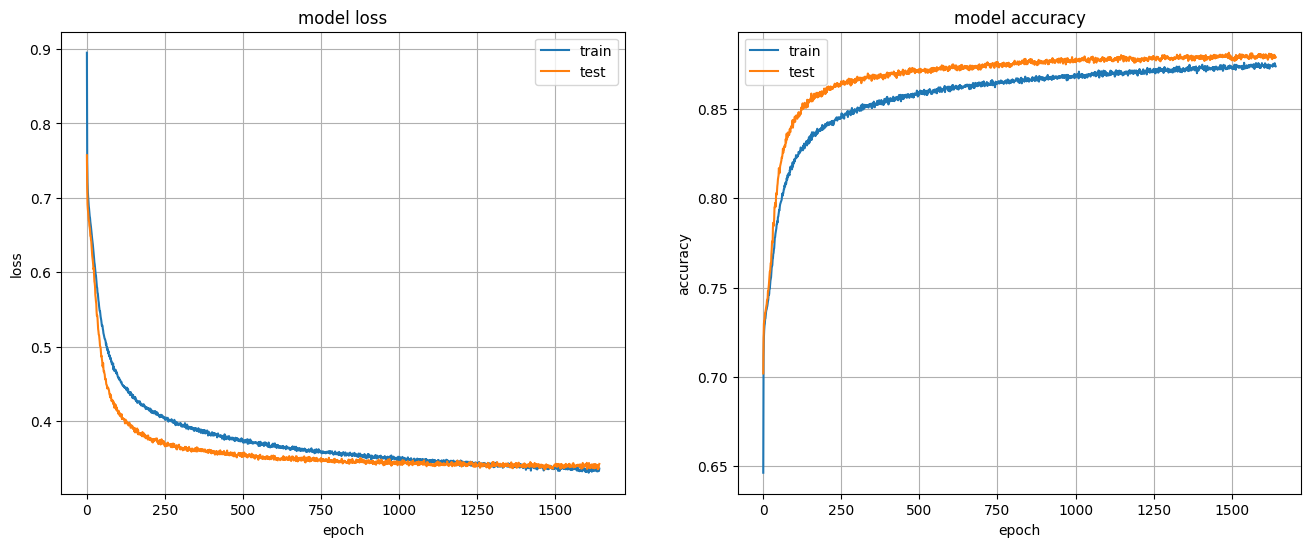

In [59]:
show_loss_accuracy_evolution(history)

751/751 [==============================] - 1s 2ms/step


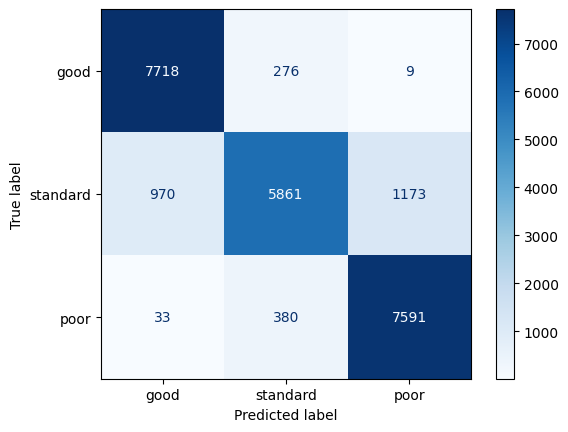

In [60]:
y_pred_nn = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_nn.argmax(axis=1), normalize=None)
cmd = ConfusionMatrixDisplay(cm, display_labels=['good', 'standard', 'poor'])
cmd.plot(cmap=plt.cm.Blues)
plt.show()

In [61]:
print(classification_report(y_test, y_pred_nn.argmax(axis=1), target_names=['good', 'standard', 'poor']))

              precision    recall  f1-score   support

        good       0.88      0.96      0.92      8003
    standard       0.90      0.73      0.81      8004
        poor       0.87      0.95      0.90      8004

    accuracy                           0.88     24011
   macro avg       0.88      0.88      0.88     24011
weighted avg       0.88      0.88      0.88     24011



# 10. Guardado de datos

In [62]:
# dataset ML
X_res.to_csv(path_output + 'X_train.csv', index=False)
y_res.to_csv(path_output + 'y_train.csv', index=False)

# # dataset NN, prueba adicional
# X_res.to_csv(path_output + 'X_train_nn.csv', index=False)
# y_res.to_csv(path_output + 'y_train_nn.csv', index=False)

In [63]:
# # checkeo de orden de variables previo almacenamiento
# ordinal.inverse_transform([[0.0], [1.0], [2.0]])

In [64]:
dictionary = dict(zip(credit_score_order, [0.0, 1.0, 2.0]))
 
# Serializing json
json_object = json.dumps(dictionary, indent=4)
 
# Writing to sample.json
with open(f"{path_output}true_label.json", "w") as outfile:
    outfile.write(json_object)

In [65]:
# # @title Convert ipynb to HTML in Colab
# # Upload ipynb
# from google.colab import files
# f = files.upload()

# # Convert ipynb to html
# import subprocess
# file0 = list(f.keys())[0]
# _ = subprocess.run(["pip", "install", "nbconvert"])
# _ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# # download the html
# files.download(file0[:-5]+"html")